Adapted from [Joseph Konan](https://github.com/jhkonan), CMU

In [ ]:
import os

os.environ["PREFIX"] = "wget -q https://cmu.box.com/shared/static"
os.environ["SUFFIX"] = "--content-disposition --show-progress"

### Download MFCC Recordings (Train/Valid)
!${PREFIX}/wok08c2z2dp4clufhy79c5ee6jx3pyj9 ${SUFFIX}
!${PREFIX}/zctr6mvh7npfn01forli8n45duhp2g85 ${SUFFIX}

### Download Phoneme Transcripts (Train/Valid)
!${PREFIX}/lbmdlr654oz7wxdtjxr4ojv2fp1iiv3b ${SUFFIX}
!${PREFIX}/zpq29b3kppklft7itgr1kuayuvl8bvrj ${SUFFIX}

f0176_mfccs_train.n 100%[===================>] 279.30M  8.33MB/s    in 31s     
f0176_mfccs_dev.npy 100%[===================>]  27.93M  12.1MB/s    in 2.3s    
f0176_hw1p2_train.n 100%[===================>]  53.71M  17.2MB/s    in 3.3s    
f0176_hw1p2_dev.npy 100%[===================>]   5.37M  4.73MB/s    in 1.1s    


In [ ]:
!pip install -q torchsummaryX

In [ ]:
import torch
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
#from torchsummaryX import summary

from tqdm.notebook import tqdm

In [ ]:
train_X = np.load("f0176_mfccs_train.npy")
train_Y = np.load("f0176_hw1p2_train.npy")

valid_X = np.load("f0176_mfccs_dev.npy")
valid_Y = np.load("f0176_hw1p2_dev.npy")

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)

(16000, 176, 26) (16000, 176) (1600, 176, 26) (1600, 176)


In [ ]:
train_X = np.concatenate(train_X)
train_Y = np.concatenate(train_Y)

valid_X = np.concatenate(valid_X)
valid_Y = np.concatenate(valid_Y)

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)

(2816000, 26) (2816000,) (281600, 26) (281600,)


In [ ]:
labels = np.unique(train_Y)
print(len(labels), labels)

40 ['AA' 'AE' 'AH' 'AO' 'AW' 'AY' 'B' 'CH' 'D' 'DH' 'EH' 'ER' 'EY' 'F' 'G'
 'HH' 'IH' 'IY' 'JH' 'K' 'L' 'M' 'N' 'NG' 'OW' 'OY' 'P' 'R' 'S' 'SH' 'T'
 'TH' 'UH' 'UW' 'V' 'W' 'Y' 'Z' 'ZH' '[SIL]']


In [ ]:
print(train_X[0])

[ 1.5970443e+01  2.5738766e+00  3.5521295e+00  5.1218557e-01
 -7.1642976e+00 -1.5948171e+01  1.4065704e+00  1.0324922e+01
  7.7373919e+00  1.1384839e+01  1.3372914e+01  3.6117899e-01
  4.3222442e+00  8.5302439e+00  1.6495329e+00  2.5865960e+00
  5.4977932e+00  8.0049807e-01 -1.5715441e+00 -2.7250130e+00
 -8.3885288e-01 -1.5004207e-01  3.5981026e-02  1.4591776e-01
  2.8248909e-01  3.5455937e-13]


In [ ]:
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, X, Y, context=0):

        ### Assign Data & Labels To Self
        self.Y = Y
        self.X = X

        ### Check & Store Item Count As Length
        assert len(self.X) == len(self.Y)
        self.length = len(self.X)

        ### Create Dict Of Tokenized Labels As Vocabulary
        labels = np.unique(self.Y)
        tokens = range(len(labels))
        self.VOCABULARY = dict(zip(labels, tokens))

        ### Map Labels To Tokens
        self.Y = [self.VOCABULARY[label] for label in self.Y]

        ### Padding
        self.context = context
        self.X = np.pad(self.X, ((context, context), (0, 0)), 'constant', constant_values= 0)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        X = self.X[i:i+2*self.context+1, :].reshape(-1)
        X = torch.FloatTensor(X)
        return X, self.Y[i]

In [ ]:
class TinyModel(torch.nn.Module):

    def __init__(self, n_x, n_h, n_y):

        super(TinyModel, self).__init__()

        self.model = torch.nn.Sequential(
                          torch.nn.Linear(n_x, n_h),
                          torch.nn.ReLU(),
                          torch.nn.Linear(n_h, n_y))

    def forward(self, x):

        x = self.model(x)

        return x

In [ ]:
def train_iter(dataloader):

    model.train()

    for x, y in tqdm(dataloader):

        loss = CEL(model(x), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return None

In [ ]:
def evaluate(dataloader):

    pred_y_list = []
    true_y_list = []

    for x, true_y in tqdm(dataloader):

        with torch.inference_mode():
            pred_y = torch.argmax(model(x), dim=1)

        pred_y_list.extend(list(pred_y.detach().numpy()))
        true_y_list.extend(list(true_y.detach().numpy()))

    accuracy = sklearn.metrics.accuracy_score(pred_y_list, true_y_list)

    return accuracy

In [ ]:
BATCH_SIZE = 512

train_dataset = ToyDataset(train_X, train_Y)

valid_dataset = ToyDataset(valid_X, valid_Y)

train_dataloader = torch.utils.data.DataLoader(
    dataset    = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle    = True)

valid_dataloader = torch.utils.data.DataLoader(
    dataset    = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle    = False)

In [ ]:
model     = TinyModel(n_x=26, n_h=1024, n_y=40)
optimizer = torch.optim.Adam(model.parameters())
CEL       = torch.nn.CrossEntropyLoss()

In [ ]:
NUM_EPOCHS = 10
train_acc = [None] * NUM_EPOCHS
val_acc = [None] * NUM_EPOCHS

for epoch in tqdm(range(NUM_EPOCHS)):

    train_iter(train_dataloader)

    train_acc[epoch] = evaluate(train_dataloader)*100
    val_acc[epoch] = evaluate(valid_dataloader)*100

    print("Train Accuracy: {}%\nValid Accuracy: {}%"
          .format(train_acc[epoch], val_acc[epoch]))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 34.61569602272727%
Valid Accuracy: 33.671875%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 36.123188920454545%
Valid Accuracy: 35.06392045454545%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 36.408061079545455%
Valid Accuracy: 35.30326704545455%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 36.55625%
Valid Accuracy: 35.31889204545455%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 36.98529829545454%
Valid Accuracy: 35.774502840909086%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 36.94477982954545%
Valid Accuracy: 35.69140625%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 37.013636363636365%
Valid Accuracy: 35.8046875%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 37.242329545454545%
Valid Accuracy: 35.87357954545455%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 37.17276278409091%
Valid Accuracy: 35.64879261363637%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 37.10845170454545%
Valid Accuracy: 35.56889204545455%


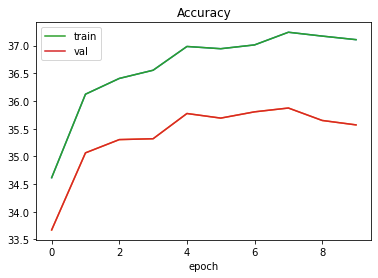

In [ ]:
epoch = range(NUM_EPOCHS)
plt.plot(epoch, train_acc, val_acc)
plt.plot(epoch, train_acc, label='train')
plt.plot(epoch, val_acc, label='val')
plt.legend()
plt.title("Accuracy")
plt.xlabel('epoch')
plt.show()

## Context

In [ ]:
BATCH_SIZE = 512
CONTEXT    = 14

train_dataset = ToyDataset(train_X, train_Y, context = CONTEXT)

valid_dataset = ToyDataset(valid_X, valid_Y, context = CONTEXT)

train_dataloader = torch.utils.data.DataLoader(
    dataset    = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle    = True)

valid_dataloader = torch.utils.data.DataLoader(
    dataset    = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle    = False)

In [ ]:
model     = TinyModel(n_x=26*(2*CONTEXT + 1), n_h=1024, n_y=40)
optimizer = torch.optim.Adam(model.parameters())
CEL       = torch.nn.CrossEntropyLoss()

In [ ]:
NUM_EPOCHS = 10
train_acc = [None] * NUM_EPOCHS
val_acc = [None] * NUM_EPOCHS

for epoch in tqdm(range(NUM_EPOCHS)):

    train_iter(train_dataloader)

    train_acc[epoch] = evaluate(train_dataloader)*100
    val_acc[epoch] = evaluate(valid_dataloader)*100

    print("Train Accuracy: {}%\nValid Accuracy: {}%"
          .format(train_acc[epoch], val_acc[epoch]))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 55.14083806818182%
Valid Accuracy: 53.40198863636364%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 55.82347301136363%
Valid Accuracy: 53.866122159090914%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 55.69801136363637%
Valid Accuracy: 53.84232954545455%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 56.46683238636364%
Valid Accuracy: 54.51136363636364%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 56.149538352272735%
Valid Accuracy: 54.28657670454545%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 56.52659801136364%
Valid Accuracy: 54.65127840909091%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 56.75862926136364%
Valid Accuracy: 54.83558238636363%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 56.44591619318182%
Valid Accuracy: 54.4453125%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 57.08004261363636%
Valid Accuracy: 55.02769886363637%


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

Train Accuracy: 56.88948863636364%
Valid Accuracy: 54.87357954545454%


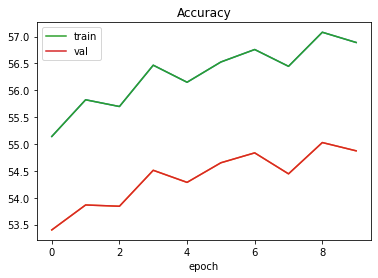

In [ ]:
epoch = range(NUM_EPOCHS)
plt.plot(epoch, train_acc, val_acc)
plt.plot(epoch, train_acc, label='train')
plt.plot(epoch, val_acc, label='val')
plt.legend()
plt.title("Accuracy")
plt.xlabel('epoch')
plt.show()